In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
## load ENTIRE dataset
max_features = 10000
(X_train_orig, y_train_orig), (X_test_orig, y_test_orig) = imdb.load_data(num_words=max_features)

# Combine train and test for maximum data
X_all = np.concatenate([X_train_orig, X_test_orig])
y_all = np.concatenate([y_train_orig, y_test_orig])

print(f"Original train shape: {X_train_orig.shape}")
print(f"Original test shape: {X_test_orig.shape}")
print(f"Combined dataset shape: {X_all.shape}")
print(f"Total samples: {len(X_all)}")

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Original train shape: (25000,)
Original test shape: (25000,)
Combined dataset shape: (50000,)
Total samples: 50000


In [3]:
## Analyze review lengths for better padding
review_lengths = [len(x) for x in X_all]
print(f"Review length statistics:")
print(f"  Min: {np.min(review_lengths)}")
print(f"  Max: {np.max(review_lengths)}")
print(f"  Mean: {np.mean(review_lengths):.2f}")
print(f"  Median: {np.median(review_lengths):.2f}")
print(f"  95th percentile: {np.percentile(review_lengths, 95):.2f}")

Review length statistics:
  Min: 7
  Max: 2494
  Mean: 234.76
  Median: 176.00
  95th percentile: 598.00


In [4]:
## Pad sequences with optimal length (95th percentile ~ 400)
maxlen = 300  # Optimal length covering 95%+ of reviews
X_all_padded = sequence.pad_sequences(X_all, maxlen=maxlen)
print(f"Padded dataset shape: {X_all_padded.shape}")

Padded dataset shape: (50000, 300)


In [5]:
## Split data for training and validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_all_padded, y_all, test_size=0.1, random_state=42, stratify=y_all
)
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

Training set: (45000, 300)
Validation set: (5000, 300)


In [6]:
## Build improved LSTM model with better architecture
model = Sequential([
    Embedding(max_features, 128, input_length=maxlen),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

print("Model architecture:")
model.summary()

Model architecture:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [7]:
## Compile with optimized settings
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [8]:
## Set up callbacks for better training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)

In [9]:
## Train the model on entire dataset
print("Training on entire dataset with validation split...")
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Training on entire dataset with validation split...
Epoch 1/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 66s 41ms/step - accuracy: 0.7633 - loss: 0.4664 - val_accuracy: 0.8998 - val_loss: 0.2651 - learning_rate: 0.0010
Epoch 2/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 55s 39ms/step - accuracy: 0.8998 - loss: 0.2568 - val_accuracy: 0.8984 - val_loss: 0.2503 - learning_rate: 0.0010
Epoch 3/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 56s 40ms/step - accuracy: 0.9318 - loss: 0.1817 - val_accuracy: 0.8924 - val_loss: 0.2619 - learning_rate: 0.0010
Epoch 4/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9492 - loss: 0.1440
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 56s 40ms/step - accuracy: 0.9492 - loss: 0.1440 - val_accuracy: 0.8902 - val_loss: 0.2920 - learning_rate: 0.0010
Epoch 5/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 56s 40ms/step - accuracy: 0.9710 - loss: 0.0912 - val_accuracy: 0.8892 - val_loss: 0.3336 - learning_rate: 5.0000e-04
Epoch 5: e


Validation Accuracy: 89.84%
Validation Loss: 0.2503


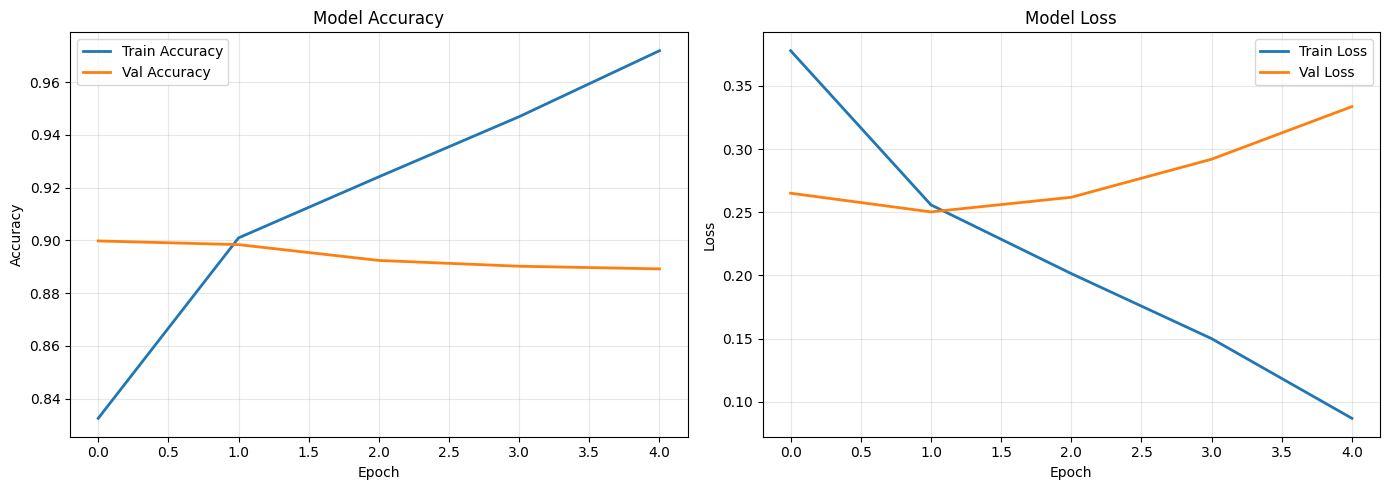

In [10]:
## Evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"\nValidation Accuracy: {val_accuracy*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

# Display training history
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Model Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
## Save the improved model
model.save('imdb_rnn_model.h5')
print("Model saved as 'imdb_rnn_model.h5'")

# Save training history
import json
history_dict = {
    'accuracy': [float(x) for x in history.history['accuracy']],
    'loss': [float(x) for x in history.history['loss']],
    'val_accuracy': [float(x) for x in history.history['val_accuracy']],
    'val_loss': [float(x) for x in history.history['val_loss']],
    'final_accuracy': float(val_accuracy),
    'final_val_loss': float(val_loss)
}
with open('training_history.json', 'w') as f:
    json.dump(history_dict, f, indent=2)
print("Training history saved!")

Model saved as 'imdb_rnn_model.h5'
Training history saved!


In [12]:
## Quick test on sample reviews
word_index = imdb.get_word_index()
reverse_word_index = {value: key for (key, value) in word_index.items()}

def decode_review(text):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in text])

def preprocess_text(text):
    words = text.lower().split()
    indices = [word_index.get(word, 2) + 3 for word in words]
    return tf.keras.preprocessing.sequence.pad_sequences([indices], maxlen=maxlen)

# Test predictions
test_reviews = [
    "This movie was absolutely fantastic! Best film I've seen in years.",
    "Terrible waste of time. Horrible acting and boring plot."
]

print("\nSample Predictions:")
for review in test_reviews:
    processed = preprocess_text(review)
    pred = model.predict(processed, verbose=0)
    sentiment = "POSITIVE" if pred[0][0] >= 0.5 else "NEGATIVE"
    print(f"Review: {review[:50]}...")
    print(f"Prediction: {sentiment} (confidence: {pred[0][0]:.4f})\n")

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Sample Predictions:
Review: This movie was absolutely fantastic! Best film I'v...
Prediction: POSITIVE (confidence: 0.9691)

Review: Terrible waste of time. Horrible acting and boring...
Prediction: NEGATIVE (confidence: 0.0026)



In [13]:
model.save('imdb_rnn_model.h5')        # HDF5 format